# 21cm Line Emission Simulations, with Different Backends

## This notebook demonstrates how to run a 21cm line emission simulation, to obtain visibilities and dirty images, and create a mosaic of pointings.

## For more details, see main code on `line_emission.py`

In [1]:
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord

from karabo.simulation.line_emission import line_emission_pipeline, CircleSkyRegion
from karabo.data.external_data import HISourcesSmallCatalogDownloadObject
from karabo.util.file_handler import FileHandler
from karabo.simulator_backend import SimulatorBackend
from karabo.imaging.image import Image, ImageMosaicker
from karabo.simulation.sky_model import SkyModel
from karabo.simulation.observation import Observation
from karabo.simulation.telescope import Telescope
from karabo.simulation.interferometer import FilterUnits, InterferometerSimulation

The RASCIL data directory is not available - continuing but any simulations will fail


In [2]:
# Image details
npixels = 4096
image_width_degrees = 2
cellsize_radians = np.radians(image_width_degrees) / npixels

# The number of time steps is then determined as total_length / integration_time.
observation_length = timedelta(seconds=10000)  # 14400 = 4hours
integration_time = timedelta(seconds=10000)

output_base_directory = Path(
    FileHandler().get_tmp_dir(
        prefix="line-emission-",
        purpose="Example line emission simulation",
    )
)

Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-b5uJStflRe for Example line emission simulation


In [3]:
# Define observation pointings
pointings = [
    CircleSkyRegion(
        radius=1 * u.deg, center=SkyCoord(ra=20, dec=-30, unit="deg", frame="icrs")
    ),
    CircleSkyRegion(
        radius=1 * u.deg,
        center=SkyCoord(ra=20, dec=-31.4, unit="deg", frame="icrs"),
    ),
    CircleSkyRegion(
        radius=1 * u.deg,
        center=SkyCoord(ra=21.4, dec=-30, unit="deg", frame="icrs"),
    ),
    CircleSkyRegion(
        radius=1 * u.deg,
        center=SkyCoord(ra=21.4, dec=-31.4, unit="deg", frame="icrs"),
    ),
]

In [4]:
# Primary beam settings
should_apply_primary_beam = False

# Create interferometer simulation
if should_apply_primary_beam:
    beam_type = "Gaussian beam"
    # Options: "Aperture array", "Isotropic beam", "Gaussian beam", "VLA (PBCOR)"
    gaussian_fwhm = 50  # Degrees
    gaussian_ref_freq = 8e8  # Hz
else:
    beam_type = "Isotropic beam"
    gaussian_fwhm = 0
    gaussian_ref_freq = 0

In [5]:
# Load catalog of sources
catalog_path = HISourcesSmallCatalogDownloadObject().get()
sky = SkyModel.get_sky_model_from_h5_to_xarray(
    path=catalog_path,
)

In [6]:
# Define observation channels and duration
observation = Observation(
    start_date_and_time=datetime(2000, 3, 20, 12, 6, 39),
    length=observation_length,
    number_of_time_steps=int(
        observation_length.total_seconds() / integration_time.total_seconds()
    ),
    start_frequency_hz=7e8,
    frequency_increment_hz=8e7,
    number_of_channels=2,
)

In [7]:
# Instantiate interferometer
# Leave time_average_sec as 10, since OSKAR examples use 10.
# Not sure of the meaning of this parameter.
interferometer = InterferometerSimulation(
    time_average_sec=10,
    ignore_w_components=True,
    uv_filter_max=10000,
    uv_filter_units=FilterUnits.Metres,
    use_gpus=True,
    station_type=beam_type,
    gauss_beam_fwhm_deg=gaussian_fwhm,
    gauss_ref_freq_hz=gaussian_ref_freq,
    use_dask=False,
)

## Simulation: compute visibilities and dirty images

In [8]:
%%time
# Run pipeline for each of the available backends
backend_to_dirty_images = {}

for simulator_backend, telescope_name in (
    (SimulatorBackend.OSKAR, "SKA1MID"),
    (SimulatorBackend.RASCIL, "MID"),
):
    telescope = Telescope.constructor(telescope_name, backend=simulator_backend)

    visibilities, dirty_images = line_emission_pipeline(
        output_base_directory=output_base_directory,
        simulator_backend=simulator_backend,
        imaging_backend=None,  # Cause pipeline to use same backend as simulator_backend
        pointings=pointings,
        sky_model=sky,
        observation_details=observation,
        telescope=telescope,
        interferometer=interferometer,
        image_npixels=npixels,
        image_cellsize_radians=cellsize_radians,
    )

    backend_to_dirty_images[simulator_backend] = dirty_images

print("Done with line emission pipelines")

Selected backend: SimulatorBackend.OSKAR
Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-b5uJStflRe directory if it does not exist yet.
Computing visibilities...
Processing frequency channel 0...
Processing pointing 0...
Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/interferometer-XcZK05mQis for interferometer disk-cache.
Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-b5uJStflRe/visibilities_f0_p0
Processing pointing 1...
Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-b5uJStflRe/visibilities_f0_p1
Processing pointing 2...
Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-b5uJStflRe/visibilities_f0_p2
Processing pointing 3...
Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-b5uJStflRe/visibilities_f0_p3
Processing frequency channel 1...
Processing pointing 0...
Saved visibility to /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-b5uJStflRe/visibilities_f1_p0
Processing pointing 1...
Saved v

/users/lmachado/Karabo-Pipeline/karabo/imaging/image.py:117: UserWarning: Received 3D data for image object.
                Will assume the 3 axes correspond to
                (polarisations, pixels_x, pixels_y).
                Inserting 1 additional axis for frequencies.
  warnings.warn(


Processing pointing 1...
W|                                                                   
W|== WARNING: Skipped 3227 visibility points.
W|                                                                   
Processing pointing 2...
W|                                                                   
W|== WARNING: Skipped 3227 visibility points.
W|                                                                   
Processing pointing 3...
W|                                                                   
W|== WARNING: Skipped 3226 visibility points.
W|                                                                   
Processing frequency channel 1...
Processing pointing 0...
W|                                                                   
W|== WARNING: Skipped 3564 visibility points.
W|                                                                   
Processing pointing 1...
W|                                                                   
W|== WARNING: Skipped 3572 

Selected backend: SimulatorBackend.RASCIL
Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/line-emission-b5uJStflRe directory if it does not exist yet.
Computing visibilities...
Processing frequency channel 0...
Processing pointing 0...
Processing pointing 1...
Processing pointing 2...
Processing pointing 3...
Processing frequency channel 1...
Processing pointing 0...
Processing pointing 1...
Processing pointing 2...
Processing pointing 3...
Creating dirty images from visibilities...
Processing frequency channel 0...
Processing pointing 0...
Processing pointing 1...
Processing pointing 2...
Processing pointing 3...
Processing frequency channel 1...
Processing pointing 0...
Processing pointing 1...
Processing pointing 2...
Processing pointing 3...
Done with line emission pipelines
CPU times: user 49.3 s, sys: 10.3 s, total: 59.6 s
Wall time: 53.4 s


In [9]:
%%time
# Create mosaics of pointings for each frequency channel
mosaicker = ImageMosaicker()

backend_to_mosaics = {}

for simulator_backend, dirty_images in backend_to_dirty_images.items():
    print(f"Computing mosaic for {simulator_backend = }")
    backend_to_mosaics[simulator_backend] = []

    for index_freq in range(observation.number_of_channels):
        mosaic, _ = mosaicker.mosaic(dirty_images[index_freq])
        backend_to_mosaics[simulator_backend].append(mosaic)

Computing mosaic for simulator_backend = <SimulatorBackend.OSKAR: 'OSKAR'>
Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/Image-BcqSn4CV8I for restored fits-path
Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/Image-IYB3InxU9k for restored fits-path
Computing mosaic for simulator_backend = <SimulatorBackend.RASCIL: 'RASCIL'>
Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/Image-HxcGDw4eib for restored fits-path
Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/Image-ZOp5v3AJ1Q for restored fits-path
CPU times: user 4min 15s, sys: 51.5 s, total: 5min 6s
Wall time: 5min 6s


In [10]:
# Add all mosaics across frequency channels to create one final mosaic image
backend_to_summed_mosaics = {}

for simulator_backend, mosaics in backend_to_mosaics.items():
    summed_mosaic = Image(
        data=sum(m.data for m in mosaics),
        header=mosaics[0].header,
    )
    backend_to_summed_mosaics[simulator_backend] = summed_mosaic

Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/Image-YxArZkooE7 for restored fits-path
Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/Image-zFolSnL0xC for restored fits-path


## Visualization of dirty images and mosaics

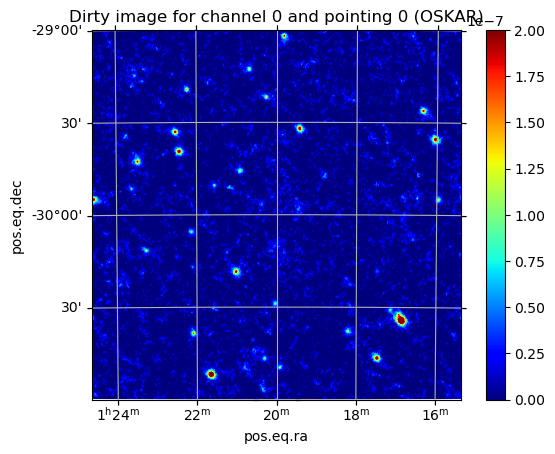

In [11]:
%matplotlib inline
backend_to_dirty_images[SimulatorBackend.OSKAR][0][0].plot(
    block=True,
    vmin=0,
    vmax=2e-7,
    title="Dirty image for channel 0 and pointing 0 (OSKAR)",
)

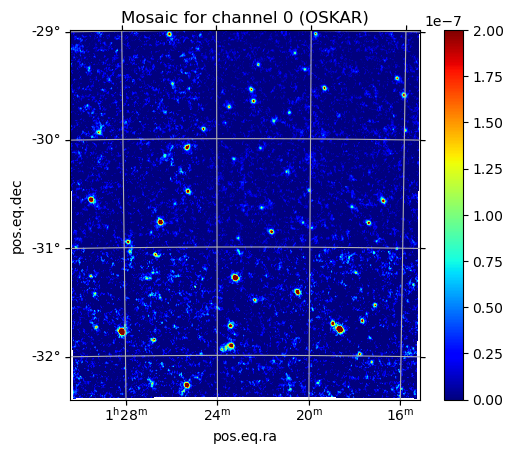

In [12]:
%matplotlib inline
backend_to_mosaics[SimulatorBackend.OSKAR][0].plot(
    block=True,
    vmin=0,
    vmax=2e-7,
    title="Mosaic for channel 0 (OSKAR)",
)

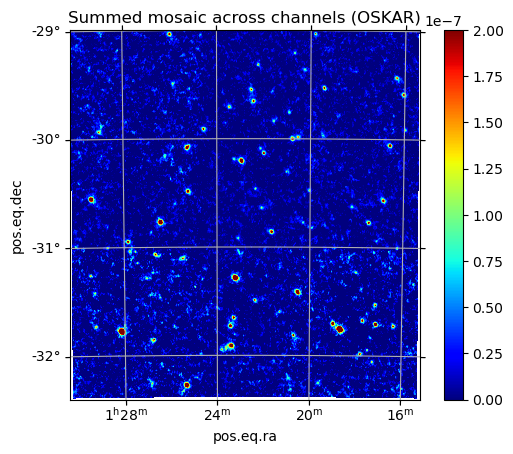

In [13]:
%matplotlib inline
backend_to_summed_mosaics[SimulatorBackend.OSKAR].plot(
    block=True,
    vmin=0,
    vmax=2e-7,
    title="Summed mosaic across channels (OSKAR)",
)

## Comparison of mosaics for different backends

Creating /tmp/karabo-STM-lmachado-dkFX6JA2Mz/Image-u6tgjyIi1P for restored fits-path


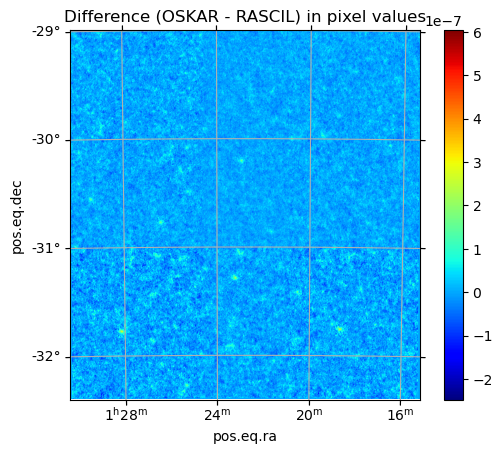

In [14]:
%matplotlib inline

# Compute difference in pixel values between mosaics from different backends
difference_in_data = (
    backend_to_summed_mosaics[SimulatorBackend.OSKAR].data
    - backend_to_summed_mosaics[SimulatorBackend.RASCIL].data
)
difference_header = backend_to_summed_mosaics[SimulatorBackend.OSKAR].header

difference_image = Image(
    data=np.nan_to_num(difference_in_data),  # To convert NaN into 0 at borders of image
    header=difference_header,
)

difference_image.plot(
    block=True,
    title="Difference (OSKAR - RASCIL) in pixel values",
)